The EOP file 'finals2000A.all' in C:\Users\Lorenzo/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in C:\Users\Lorenzo/src/iers/ is already the latest.
Timestep 864.0000 ss
Run time 38614.48s/643.57m


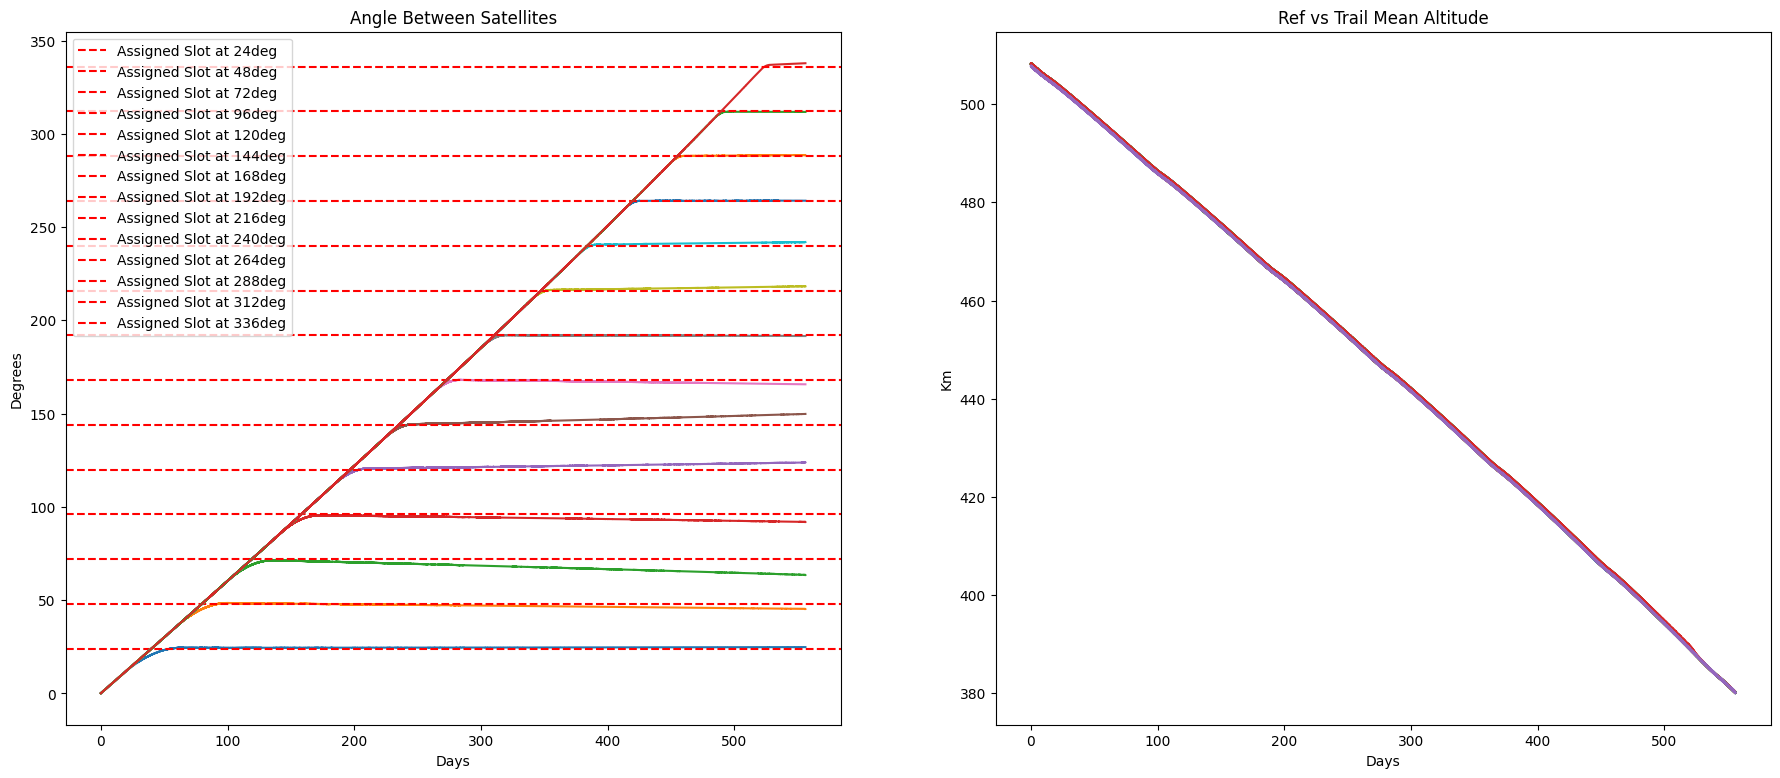

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high


toc = time.time()

## Orbit
h = 510
#alpha_wait = [0.75,0.9,0.93,0.96,0.95]
# alpha_hd = [4.4,4,3.8,3.3,3.1]
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

assignment = [24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336]                                                       
delta_a = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
delta_nu = [-0.1,-0.1,-0.1,-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]

epoch = Time(val=start_date.isoformat(), format='isot')
time_step = 864<<u.s
pred_days = []

refsmalist = []
refsmalist_mean = []

trail_sats = 14

for i in range(trail_sats):
    pred_days.append(assignment[i] - delta_nu[i])

trailsmalist = [[] for i in range(trail_sats)]
trailsmalist_mean = [[] for i in range(trail_sats)]
elapsedsecs = [[] for i in range(trail_sats)]
angle_list = [[] for i in range(trail_sats)]

reference_orbit_list = []
trailing_orbit_list = []

start_date_prop = epoch
att_range = 2

for sat in range(trail_sats):
    secs = 0

    reference_orbit = Orbit.from_classical(
        Earth,
        a,
        ecc,
        inc.to(u.rad),
        raan.to(u.rad),
        argp.to(u.rad),
        nu.to(u.rad),
        start_date_prop
        )
    trailing_orbit = Orbit.from_classical(
        Earth,
        (a.value+delta_a[sat])<<u.km,
        ecc,
        inc.to(u.rad),
        raan.to(u.rad),
        argp.to(u.rad),
        ((nu.value+delta_nu[sat])<<u.deg).to(u.rad),
        start_date_prop
        )

    ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
    trail_mean = osc2mean(a.value+delta_a[sat], ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu[sat])
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu[sat]<<u.deg), epoch)
    theta_err = (assignment[sat] - argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))%360
    
    # tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    # tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
    # tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)
    # theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)

    if assignment[sat] > 300:
        att_range = 1

    for attempts in range(att_range):
        tra_orb_pred_high = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
        tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
        tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

        tra_orb_pred_low = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
        tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
        tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

        theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days[sat]*60*60*24)<<u.s)  
        t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = ((theta_err - theta_hd.value)%360 / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s)))

        pred_days[sat] = ((t_wait+t_hd.value)/(60*60*24))**(1+((trail_mean_orbit.a.value-Earth.R_mean.to_value(u.km)+(trail_mean_orbit.a.value-ref_mean_orbit.a.value))/10000))

    ############################################
        
    if t_wait > (100*60*60*24):

        t_wait_wait = t_wait * 0.9

        num_wait_wait = int(t_wait_wait / time_step.value)
        tofs_wait_wait = TimeDelta(np.linspace(0, t_wait_wait<<u.s, num=num_wait_wait))
        reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_orbit.epoch + tofs_wait_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_orbit.epoch + tofs_wait_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))


        for t in range(len(tofs_wait_wait)):

            secs += time_step.value

            ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
            trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

            if sat == trail_sats-1:
                refsmalist.append(ref_from_ephem.a.value)
            trailsmalist[sat].append(trail_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)

            )
            trail_mean = osc2mean(
                trail_from_ephem.a.value,
                trail_from_ephem.ecc.value,
                trail_from_ephem.inc.to_value(u.deg),
                trail_from_ephem.raan.to_value(u.deg),
                trail_from_ephem.argp.to_value(u.deg),
                trail_from_ephem.nu.to_value(u.deg)
            )


            if sat == trail_sats-1:
                refsmalist_mean.append(ref_mean[0])
            trailsmalist_mean[sat].append(trail_mean[0])
            
            angle_list[sat].append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

            elapsedsecs[sat].append(secs)

        reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

        pred_days[sat] = (assignment[sat] - angle_list[sat][-1])%360

        ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, reference_orbit.nu.to(u.deg), reference_orbit.epoch)
        trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, trailing_orbit.nu.to(u.deg), trailing_orbit.epoch)


        theta_err = (assignment[sat] - argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))%360

        for attempts in range(2):
            tra_orb_pred_high = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
            tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
            tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

            tra_orb_pred_low = trailing_orbit.propagate(pred_days[sat]<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
            tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
            tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

            theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days[sat]*60*60*24)<<u.s)  

            #theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)
            t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
            theta_hd = 0.5 * theta_dot_dot * t_hd**2
            t_wait = ((theta_err - theta_hd.value)%360 / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))) #- t_hd.value 
            
            if pred_days[sat] < 500:
                pred_days[sat] = ((t_wait+t_hd.value)/(60*60*24))**(1+((trailing_orbit.a.value-Earth.R_mean.to_value(u.km)+(trailing_orbit.a.value-reference_orbit.a.value))/10000)) 


    ###########################################


    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_orbit.epoch + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_orbit.epoch + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat == trail_sats-1:
            refsmalist.append(ref_from_ephem.a.value)
        trailsmalist[sat].append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat == trail_sats-1:
            refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

        elapsedsecs[sat].append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat == trail_sats-1:
            refsmalist.append(ref_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean.append(ref_mean[0])


        trailsmalist[sat].append(trail_from_ephem.a.value)

        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )


        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

        elapsedsecs[sat].append(secs)



    reference_orbit_list.append(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1]))
    trailing_orbit_list.append(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1]))



for sat in range(trail_sats):
    t_prop = ((elapsedsecs[-1][-1] - elapsedsecs[sat][-1]) + 60*60*24*7*4)<<u.s
    num_prop = int(t_prop.value / time_step.value)
    tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

    reference_ephem = reference_orbit_list[sat].to_ephem(EpochsArray(reference_orbit_list[sat].epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit_list[sat].to_ephem(EpochsArray(trailing_orbit_list[sat].epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))    

    for t in range(len(tofs_prop)):
        
        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])
    
        if sat == trail_sats-1:
            secs += time_step.value
            elapsedsecs[sat].append(secs)

            refsmalist.append(ref_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean.append(ref_mean[0])



        trailsmalist[sat].append(trail_from_ephem.a.value)

        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

    reference_orbit_list.append(ref_from_ephem)
    trailing_orbit_list.append(trail_from_ephem)


elapsed_days = []

for sec in range(len(elapsedsecs[-1])):
    elapsed_days.append(elapsedsecs[-1][sec]/(60*60*24))

ref_mean_altitudes = []
for sma in range(len(refsmalist_mean)):
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

trail_mean_altitudes = [[] for i in range(trail_sats)]
for sat in range(trail_sats):
    for sma in range(len(trailsmalist_mean[sat])):
        trail_mean_altitudes[sat].append(trailsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))
        

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

for i in range(trail_sats):
    ax[0,0].plot(elapsed_days,angle_list[i])
    ax[0,0].axhline(assignment[i],linestyle='--',color='red',label = f'Assigned Slot at {assignment[i]}deg')

ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

for i in range(trail_sats):
    ax[0,1].plot(elapsed_days,trail_mean_altitudes[i],label='Trail')

ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

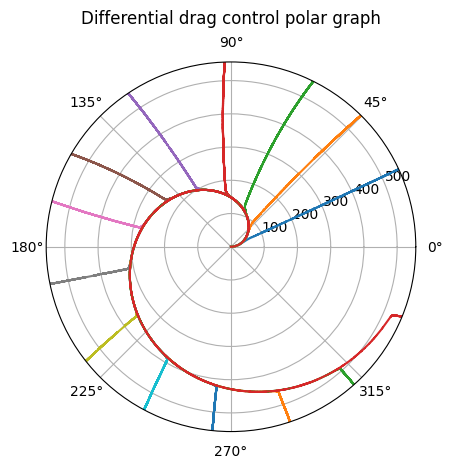

In [2]:
radians = [[] for i in range(trail_sats)]
rad_assignment = [[] for i in range(trail_sats)]
for sat in range(trail_sats):
    rad_assignment[sat].append(np.deg2rad(assignment[sat]))
    for deg in range(len(angle_list[sat])):
        radians[sat].append(np.deg2rad(angle_list[sat][deg]))
    for deg in range(len(angle_list[sat])-1):
        rad_assignment[sat].append(np.deg2rad(assignment[sat]))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(trail_sats):
    ax.plot(radians[i], elapsed_days)
  #  ax.plot(rad_assignment[i],elapsed_days,linestyle='--',color='red',label = f'Assigned Slot at {assignment[i]}deg')
ax.set_rmax(elapsed_days[-1])
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Differential drag control polar graph", va='bottom')
plt.show()